In [61]:
from data_reading import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [62]:
np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)

X = np.vstack((x_test,x_train))
y = np.hstack((y_test,y_train))
np.shape(X), np.shape(y)
# X = X.reshape(-1,28*28)
X

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [63]:
#Helper function
def prepare_data(X, y, n_init, use_classes=None, use_features=None, seed=None):
    """Extract classes and features and split data in training, pool, and test
    sets.

    PARAMETERS
    ----------
    iris
        The iris data object.
    use_classes : list | None
        The classes to be used. List of class labels (0, 1, 2) or None for all.
    use_features : list | None
        The features to be used. List of feature indices (0, 1, 2, 3) or None for all.
    n_init : int
        Number of initial data points in the training set.
    seed : int
        Seed for reproducibility.
    """          

    # Extract classes and features
    if use_classes is not None:
        use_examples = np.isin(y, use_classes)
        X = X[use_examples]
        y = y[use_examples]
    if use_features is not None:
        X = X[:, use_features]

    n = len(X)
    assert n_init <= n

    # Split in train, pool, and test set
    # Use stratified split to make sure we sample all classes equally
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_init / n, random_state=seed)
    train, pool = next(sss.split(X, y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    pool_, test = next(sss.split(X[pool], y[pool]))

    return dict(
        train = dict(
            X=X[train],
            y=y[train]
        ),
        pool = dict(
            X=X[pool[pool_]],
            y=y[pool[pool_]]
        ),
        test = dict(
            X=X[pool[test]],
            y=y[pool[test]]
        )
    )

In [64]:
def evaluate_uncertainty(prob, strategy):
    """Evaluate the desired uncertainty sampling strategy on predictive
    probabilities 'prob'.

    PARAMETERS
    ----------
    prob : ndarray 
        numpy array with predictive probabilities of shape 
        (n_points, n_classes)
    strategy : str
        One of 'least confident', 'margin', or 'entropy'.

    The function should return an array with uncertainties of shape
    (n_points, ) corresponding to the desired strategy.
    """
    # solution::start
    if strategy == 'least confident':
        res = 1 - prob.max(1)
    elif strategy == 'margin':
        ix = np.arange(len(prob))
        p2, p1 = prob.argsort(1)[:, -2:].T
        res = 1 - (prob[ix, p1] - prob[ix, p2])
    elif strategy == 'entropy':
        res = - np.sum(prob * np.log2(prob), axis=1)
    else:
        raise ValueError
    return res
    # solution::end

In [65]:
def make_grid(X1, X2=None, grid_resolution=0.01):
    """Define a grid on which to evaluate uncertainty.

    X1 : (n_examples, n_features)
    X2 : (n_examples, n_features)

    X1 (and X2) define(s) the bounds of the grid.
    """
    assert X1.shape[1] == 28*28, 'Cannot make grid if the number of features is not two.'

    if X2 is not None:
        X = np.concatenate((X1, X2))
    else:
        X = X1

    # Grid on which to evaluate model. The grid is based on the extent of the data
    lb = np.floor(X.min(0))
    ub = np.ceil(X.max(0)) + grid_resolution
    grid = np.mgrid[tuple(slice(i, j, grid_resolution) for i,j in zip(lb, ub))]

    # Some keyword-arguments to the plotting function
    dg = grid_resolution/2
    extent = (lb[0]-dg, ub[0]-dg, lb[1]-dg, ub[1]-dg)
    imshow_kwargs = dict(origin='lower', extent=extent)

    return grid, imshow_kwargs

In [66]:
n_init = 20             # Number of points to use for fitting the model
use_classes = [0,1,2,3,4,5,6,7,8,9]    # None (all three classes or a list of class labels to use, e.g., [0, 1])
use_features = range(0,28)  # The two features to use. Should be in the set (0, 1, 2, 3)
seed = 0

# Prepare the data (extract and split)
data = prepare_data(X, y, n_init, use_classes, use_features, seed=seed)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert target labels to one-hot encoded vectors
y_train_one_hot = to_categorical(data['train']['y'])

# Fit the model with one-hot encoded target labels
model.fit(data['train']['X'], y_train_one_hot, epochs=5, batch_size=64, verbose=1)


Epoch 1/5
1/1 [==============================] - 0s 379ms/step - loss: 45.5499 - accuracy: 0.0500
Epoch 2/5
1/1 [==============================] - 0s 0s/step - loss: 19.6787 - accuracy: 0.2000
Epoch 3/5
1/1 [==============================] - 0s 18ms/step - loss: 19.7877 - accuracy: 0.2500
Epoch 4/5
1/1 [==============================] - 0s 33ms/step - loss: 18.4657 - accuracy: 0.4500
Epoch 5/5
1/1 [==============================] - 0s 15ms/step - loss: 11.7157 - accuracy: 0.6000


1750/1750 [==============================] - 13s 7ms/step


C:\Users\nunni\AppData\Local\Temp\ipykernel_9824\1580969989.py:24: RuntimeWarning: divide by zero encountered in log2
  res = - np.sum(prob * np.log2(prob), axis=1)
C:\Users\nunni\AppData\Local\Temp\ipykernel_9824\1580969989.py:24: RuntimeWarning: invalid value encountered in multiply
  res = - np.sum(prob * np.log2(prob), axis=1)


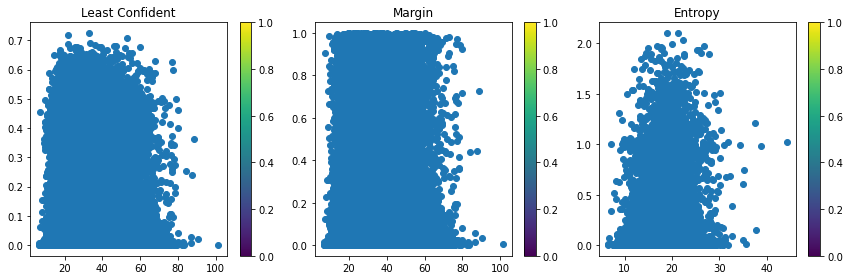

In [67]:
prob = model.predict(data['pool']['X'])
least_confident = evaluate_uncertainty(prob, 'least confident')
margin = evaluate_uncertainty(prob, 'margin')
entropy = evaluate_uncertainty(prob, 'entropy')

mean_intensity = np.mean(data['pool']['X'].reshape(len(data['pool']['X']), -1), axis=1)

# Plot uncertainties
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Least Confident')
plt.scatter(mean_intensity, least_confident, cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('Margin')
plt.scatter(mean_intensity, margin, cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Entropy')
plt.scatter(mean_intensity, entropy, cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import numpy as np 

def make_grid(X1, X2=None, grid_resolution=0.01):
    """Define a grid on which to evaluate uncertainty.

    X1 : (n_examples, n_features)
    X2 : (n_examples, n_features)

    X1 (and X2) define(s) the bounds of the grid.
    """
    assert X1.shape[1] == 28, 'Cannot make grid if the number of features is not 28.'

    if X2 is not None:
        X = np.concatenate((X1, X2))
    else:
        X = X1

    # Grid on which to evaluate model. The grid is based on the extent of the data
    lb = np.floor(X.min(0))
    ub = np.ceil(X.max(0)) + grid_resolution
    grid = np.mgrid[tuple(slice(i, j, grid_resolution) for i,j in zip(lb, ub))]

    # Some keyword-arguments to the plotting function
    dg = grid_resolution/2
    extent = (lb[0]-dg, ub[0]-dg, lb[1]-dg, ub[1]-dg)
    imshow_kwargs = dict(origin='lower', extent=extent)

    return grid, imshow_kwargs


def plot_grid(probabilities, least_confident, margin, entropy, data, grid, imshow_kwargs):
    """Plot the probabilities of each class from the logistic regression classifier
    (numpy array with shape [n_points, n_classes, 3]) along with the result of
    applying each sampling strategy (numpy arrays with shape [n_points, n_classes]).

    (Some additional variables are needed for making the plots.)
    """
    n1, n2 = grid.shape[1:]

    # This is just to be able to plot the two class problem as RGB
    # (ignore the blue channel)
    n_classes = probabilities.shape[-1]
    if n_classes == 2:
        probabilities = np.column_stack((probabilities, np.zeros(len(probabilities))))

    plot_dict = {
        'Probabilities': {
            'data': probabilities.reshape(n1, n2, 3).transpose(1,0,2),
            'point to mark': None
        },
        'Least Confident': {
            'data': least_confident.reshape(n1, n2).T,
            'point to mark': 'max'
        },
        'Margin': {
            'data': margin.reshape(n1, n2).T,
            'point to mark': 'max'
        },
        'Entropy': {
            'data': entropy.reshape(n1, n2).T,
            'point to mark': 'max'
        }
    }
    # Make the plot
    # (please ignore the colormap of the 'Probabilities' plot. It should not be
    # there!)
    fig = plt.figure(figsize=(12, 12))
    imgrid = ImageGrid(fig, 111,
                    nrows_ncols=(2,2),
                    axes_pad=(0.15, 0.35),
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="each",
                    )
    for ax, name in zip(imgrid, plot_dict):
        pd = plot_dict[name]
        im = ax.imshow(pd['data'], **imshow_kwargs)
        ax.cax.colorbar(im)
        ax.scatter(*data['train']['X'].T, c=data['train']['y'], cmap='jet')
        g = ax.scatter(*data['pool']['X'].T, c=data['pool']['y'], cmap='jet')
        g.set_facecolors('none')
        title = name
        # Mark max/min
        if pd['point to mark'] is not None:
            if pd['point to mark'] == 'max':
                point = np.where(pd['data'] == pd['data'].max())
            elif pd['point to mark'] == 'min':
                point = np.where(pd['data'] == pd['data'].min())
            point = grid[:, point[1], point[0]].squeeze()
            ax.scatter(*point, marker='P', color='k', s=80)
            title += f" ({pd['point to mark']} : {point})"
        ax.set_title(title)


In [70]:
# Compute the uncertainties
least_confident = evaluate_uncertainty(prob, 'least confident')
margin = evaluate_uncertainty(prob, 'margin')
entropy = evaluate_uncertainty(prob, 'entropy')

# solution::end
grid, imshow_kwargs = make_grid(data['train']['X'], data['pool']['X'])
pool = grid.transpose(1,2,0).reshape(-1, len(use_features))

# Once calculated, plot the uncertainty metrics
plot_grid(prob, least_confident, margin, entropy, data, grid, imshow_kwargs)

C:\Users\nunni\AppData\Local\Temp\ipykernel_9824\1580969989.py:24: RuntimeWarning: divide by zero encountered in log2
  res = - np.sum(prob * np.log2(prob), axis=1)
C:\Users\nunni\AppData\Local\Temp\ipykernel_9824\1580969989.py:24: RuntimeWarning: invalid value encountered in multiply
  res = - np.sum(prob * np.log2(prob), axis=1)


AttributeError: 'tuple' object has no attribute 'step'